## Q1. Test Drive ACLOSE algorithm to mine closed frequent patterns on a sample dataset of your choice. Test the same on a FIMI benchmark dataset which you have used for Apriori/FP-growth implementations.

In [1]:
from skmine.datasets.fimi import fetch_mushroom
from skmine.datasets.utils import describe
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# DATASET 1 : mushroom
## By default, its in horizontal transaction database format
mushroom = fetch_mushroom()

#mushroom dataset has two extra items
n_items = describe(mushroom)['n_items']+2
n_transactions = describe(mushroom)['n_transactions']

# changing it to zero indexing
for i in range(n_transactions):
    temp = []
    for j in mushroom[i]:
        temp.append(j-1)
    mushroom[i] = temp.copy()

describe(mushroom)

{'n_items': 117,
 'avg_transaction_size': 22.0,
 'n_transactions': 8124,
 'density': 0.18803418803418803}

In [82]:
#Classical Apriori function
def count_itemset(dataset_v, itemset):
    temp_set = set()
    temp_set = dataset_v[itemset[0]]
    for item in itemset:
        temp_set = temp_set.intersection(dataset_v[item])
    return len(temp_set)

def candidate_with_min_support(dataset_v, C, min_support_count):
    L = list()
    for itemset in C:
        if count_itemset(dataset_v, itemset) > min_support_count:
            L.append(itemset)
    return L

def get_vertical_dataset(horizontal_dataset, n_transactions):
    dataset_v = dict()
    for k in range(n_items):
        dataset_v[k] = set()
        
    for i in range(n_transactions):
        for j in horizontal_dataset[i]:
            dataset_v[j].add(i)
    
    return dataset_v

def get_c2(L1):
    C2 = list()
    for i in range(len(L1)):
        for j in range(len(L1)):
            if i < j:
                C2.append([L1[i][0], L1[j][0]])
    return C2

#Two itemsets are said to be compatible here if they overlap except the last item
def is_compatible(itemset1, itemset2):
    l = len(itemset1)
    flag = True
    for i in range(l-1):
        if itemset1[i] != itemset2[i]:
            flag = False
    return flag

def get_candidate_itemsets_k(L):
    Ck = list()
    for i in range(len(L)):
        for j in range(len(L)):
            if i < j and is_compatible(L[i], L[j]):
                l = len(L[i])
                temp_itemset = list()
                for z in range(l-1):
                    temp_itemset.append(L[i][z])
                temp_itemset.append(L[i][l-1])
                temp_itemset.append(L[j][l-1])
                Ck.append(temp_itemset)
    return Ck

def can_it_be_pruned(itemset, L_prev):
    l = len(itemset)
    flag = False
    for i in range(l):
        temp_itemset = itemset.copy()
        temp_itemset.remove(itemset[i])
        if temp_itemset not in L_prev:
            flag = True
    return flag

def prune(C_now, L_prev):
    temp_C = list()
    for itemset in C_now:
        if can_it_be_pruned(itemset, L_prev) == False:
            temp_C.append(itemset)
    return temp_C

#t(x) returns transaction_list having x item_list
def t(item_list, dataset_v):
    temp_set = set()
    temp_set = dataset_v[item_list[0]]
    for item in item_list:
        temp_set = temp_set.intersection(dataset_v[item])
    return list(temp_set)

#i(y) returns item_list present in all transactions of y transaction_list
def i(transaction_list, dataset):
    temp_set = set()
    temp_set = set(dataset[transaction_list[0]])
    for transaction in transaction_list:
        temp_set = temp_set.intersection(set(dataset[transaction]))
    return list(temp_set)

def merge_L(L):
    tn = len(L)
    merged_L = list()
    for i in range(1,tn):
        for item_list in L[i]:
            merged_L.append(item_list)
    return merged_L

def is_subset(itemlist_i, itemlist_j):
    return set(itemlist_i).issubset(set(itemlist_j))

def remove_sets_of_same_support(temp_L, L, dataset_v):
    merged_L = merge_L(L)
    index_set = set()
    for i in range(len(merged_L)):
        for j in range(len(temp_L)):
            if (is_subset(merged_L[i], temp_L[j]) and len(t(merged_L[i], dataset_v)) == len(t(temp_L[j], dataset_v))):
                index_set.add(j)
    
    final_L = list()
    for i in range(len(temp_L)):
        if i not in index_set:
            final_L.append(temp_L[i])
            
    return final_L
    
# type(dataset) = pandas.core.series.Series
# dataset is in horizontal database format
# min_support = [0, 1]
def aclose(dataset, min_support, n_transactions, n_items):
    #dataset_v will have the dataset in vertical database format
    dataset_v = get_vertical_dataset(dataset, n_transactions)
    
    C = list()
    L = list()
    min_support_count = int(min_support * (n_transactions))
    C.append([False]) #initialising C0
    L.append([False]) #initialising L0
    
    #C1
    temp_C = [[k] for k in range(n_items)]
    C.append(temp_C)
    
    #L1
    temp_L = candidate_with_min_support(dataset_v, C[1], min_support_count)
    L.append(temp_L)
    
    if(len(L[1]) > 0):
        #C2
        temp_C = get_c2(L[1])
        C.append(temp_C)
        
        #L2
        temp_L = candidate_with_min_support(dataset_v, C[2], min_support_count)
        temp_L = remove_sets_of_same_support(temp_L, L, dataset_v)
        L.append(temp_L)
        
    
#     print(mushroom)
#     print(t([33,35,38],dataset_v))
#     print(i([1,2,3,4,5,6,7,8],dataset))

    flag = True
    last_l = len(L)-1;
    k = last_l + 1
    if(len(L[last_l]) == 0):
        flag = False
        
    while flag:
        #CK
        temp_C = get_candidate_itemsets_k(L[k-1])
        temp_C = prune(temp_C, L[k-1])
        C.append(temp_C)
        
        temp_L = candidate_with_min_support(dataset_v, C[k], min_support_count)
        temp_L = remove_sets_of_same_support(temp_L, L, dataset_v)
        L.append(temp_L)
        
        k = k + 1
        
        flag = True
        last_l = len(L)-1;
        k = last_l + 1
        if(len(L[last_l]) == 0):
            flag = False
            
    #Deriving closed itemsets
    closed_itemsets = set()
    merged_L = merge_L(L)
#     print(len(merged_L))
    for itemlist in merged_L:
        closed_itemsets.add(tuple(i(t(itemlist, dataset_v), dataset)))
#     print(len(closed_itemsets))
    closed_itemlist = list()
    for itemtuple in closed_itemsets:
        closed_itemlist.append(list(itemtuple))

    return closed_itemlist

In [88]:
closed_itemsets = aclose(mushroom, 0.4, n_transactions, n_items)
print(closed_itemsets)

[[33, 38, 84, 85, 58], [33, 66, 84, 85, 89], [33, 35, 84, 85, 58], [33, 84, 85, 89, 92], [58, 84, 38], [89, 84, 38], [84], [33, 84, 23], [33, 75, 84, 85, 58], [33, 35, 38, 84, 85], [33, 84, 85, 89, 58], [33, 35, 84, 85, 55, 89], [33, 51, 84, 85], [35, 84, 89, 58, 62], [33, 84], [33, 35, 109, 84, 85], [58, 35, 84], [89, 35, 84], [33, 84, 85, 23], [89, 35, 84, 38], [84, 85, 38], [33, 35, 84, 85, 23], [35, 84, 85, 23], [33, 35, 52, 85, 84, 89], [33, 27, 84, 85], [51, 84, 85], [58, 35, 84, 92], [35, 84, 92], [33, 35, 84, 85, 62], [89, 84, 33], [33, 35, 84, 85], [38, 84, 62], [33, 35, 84, 85, 89], [33, 38, 84, 85, 89], [84, 109], [33, 84, 85, 89, 62], [51, 84], [33, 35, 84, 85, 89, 58], [35, 84, 85], [33, 35, 84, 85, 55], [33, 27, 84], [33, 2, 84, 85, 89], [84, 38], [35, 84, 23], [89, 35, 84, 92], [2, 84], [33, 84, 85, 38], [58, 84, 92], [89, 84, 92], [58, 35, 84, 62], [35, 84, 62], [33, 84, 85, 55, 89], [33, 84, 85, 92, 62], [33, 84, 85, 22], [33, 84, 85, 89, 58, 62], [33, 35, 84, 85, 58, 

## Q2. Test Drive Pincer search to mine maximal frequent patterns on a sample dataset of your choice. Test the same on a FIMI benchmark dataset which you have used for Apriori/FP-growth implementations.

In [1]:
from skmine.datasets.fimi import fetch_mushroom
from skmine.datasets.utils import describe
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# DATASET 1 : mushroom
## By default, its in horizontal transaction database format
mushroom = fetch_mushroom()

#mushroom dataset has two extra items
n_items = describe(mushroom)['n_items']+2
n_transactions = describe(mushroom)['n_transactions']

# changing it to zero indexing
for i in range(n_transactions):
    temp = []
    for j in mushroom[i]:
        temp.append(j-1)
    mushroom[i] = temp.copy()

describe(mushroom)

{'n_items': 117,
 'avg_transaction_size': 22.0,
 'n_transactions': 8124,
 'density': 0.18803418803418803}

In [113]:
def count_itemset(dataset_v, itemset):
    temp_set = set()
    temp_set = dataset_v[itemset[0]]
    for item in itemset:
        temp_set = temp_set.intersection(dataset_v[item])
    return len(temp_set)  

def get_vertical_dataset(horizontal_dataset):
    dataset_v = dict()
    for k in range(n_items):
        dataset_v[k] = set()
        
    for i in range(n_transactions):
        for j in horizontal_dataset[i]:
            dataset_v[j].add(i)
    
    return dataset_v

#Two itemsets are said to be compatible here if they overlap except the last item
def is_compatible(itemset1, itemset2):
    l = len(itemset1)
    flag = True
    for i in range(l-1):
        if itemset1[i] != itemset2[i]:
            flag = False
    return flag

def remove_duplicates(new_MFS):
    temp_l = list()
    for itemlist in new_MFS:
        if itemlist not in temp_l:
            temp_l.append(itemlist)
    return temp_l

def update_MFS(MFS, MFCS, min_support_count, dataset_v):
    new_MFS = MFS.copy()
    for itemset in MFCS:
        if count_itemset(dataset_v, itemset) > min_support_count:
            new_MFS.append(itemset)
    new_MFS = remove_duplicates(new_MFS)
    return new_MFS

def is_subset(itemlist_i, itemlist_j):
    return set(itemlist_i).issubset(set(itemlist_j))

def is_subset_any_MFS(itemset, MFS):
    flag = False
    for itemlist in MFS:
        if is_subset(itemset, itemlist):
            flag = True
    return flag

def get_LK_SK(dataset_v, CK, min_support_count, MFS):
    LK = list()
    SK = list()
    for itemset in CK:
        if count_itemset(dataset_v, itemset) > min_support_count:
            LK.append(itemset)
        else:
            SK.append(itemset)
            
    LK_new = list()
    for itemset in LK:
        if is_subset_any_MFS(itemset, MFS) == False:
            LK_new.append(itemset)

    return LK_new, SK

def any_itemset_CK_subset_itemset_MFS(CK, MFS):
    flag=False
    for itemset1 in CK:
        for itemset2 in MFS:
            if is_subset(itemset1, itemset2):
                flag=True
    return flag

def recovery(temp_C, LK, MFS, K):
    new_temp_C = temp_C.copy()
    for l in LK:
        for m in MFS:
            if is_compatible(l,m):
                for i in range(K-1, len(m)):
                    temp_l = l.copy()
                    temp_l.append(m[i])
                    new_temp_C.append(temp_l)
    
    return (new_temp_C)

def get_immediate_subsets(C):
    mega_list = list()
    for c in C:
        C_copy = C.copy()
        C_copy.remove(c)
        temp_list = C_copy.copy()
        mega_list.append(temp_list)
    return mega_list

def new_prune(LK, MFS, temp_C, K):
    new_temp_C = temp_C.copy()
    for c in temp_C:
        if is_subset_any_MFS(c, MFS):
            new_temp_C.remove(c)
        else:
            k_subsets_of_C = get_immediate_subsets(c)
            for s in k_subsets_of_C:
                if (s not in LK) and (c in new_temp_C):
                    new_temp_C.remove(c)
    return new_temp_C

def MFCS_gen(MFCS, SK):
    new_MFCS = MFCS.copy()
    for s in SK:
        for m in new_MFCS:
            temp_MFCS = new_MFCS.copy()
            if (is_subset(s, m)):
                if (m in temp_MFCS):
                    temp_MFCS.remove(m)
                for e in s:
                    temp_l = m.copy()
                    temp_l.remove(e)
                    #Using the same function(is_subset_any_MFS) for MFCS
                    if is_subset_any_MFS(temp_l, temp_MFCS) == False:
                        temp_MFCS.append(temp_l)
        new_MFCS = temp_MFCS.copy()
    return new_MFCS

# type(dataset) = pandas.core.series.Series
# dataset is in horizontal database format
# min_support = [0, 1]
def pincersearch(dataset, min_support, n_transactions, n_items):
    #dataset_v will have the dataset in vertical database format
    dataset_v = get_vertical_dataset(dataset)
    
    L = list()
    K = 1
    C = list()
    S = list()
    MFCS = list()
    MFS = list()
    
    C.append([False]) #initialising C0
    L.append([False]) #initialising L0
    S.append([False]) #initialising S0
    
    temp_l = list()
    for i in range(n_items):
        temp_l.append(i)
    MFCS.append(temp_l)
    
    #C1
    temp_C = [[k] for k in range(n_items)]
    C.append(temp_C)
        
#     print("L", L)
#     print("C", C)
#     print("MFCS", MFCS)
#     print("MFS", MFS)
        
    min_support_count = int(min_support * n_transactions)
#     print("min_support_count", min_support_count)
    
#     #Line 6
#     for itemset in C[1]:
#         print(itemset, count_itemset(dataset_v, itemset))
        
#     for itemset in MFCS:
#         print(itemset, count_itemset(dataset_v, itemset))

    while len(C[K]):
        #Line 7
        MFS = update_MFS(MFS, MFCS, min_support_count, dataset_v)
#         print("MFS", MFS)

        #Line 8 and 9
        LK, SK = get_LK_SK(dataset_v, C[K], min_support_count, MFS)
        L.append(LK)
        S.append(SK)
#         print("L", L)
#         print("S", S)

        #Line 10
        temp_C = get_candidate_itemsets_k(L[K])
#         print("temp_C", len(temp_C))

        #Line 11 and 12
        if any_itemset_CK_subset_itemset_MFS(C[K], MFS):
            temp_C = recovery(temp_C, L[K], MFS, K)
#         print("MFS", len(MFS))
#         print("temp_C", len(temp_C))

        #Line 13
        temp_C = new_prune(L[K], MFS, temp_C, K)
#         print("temp_C", len(temp_C))
        C.append(temp_C)

        #Line 14
        MFCS = MFCS_gen(MFCS, S[K])
#         print("MFCS", (MFCS))

        #Line 15
        K = K + 1

    return MFS

In [114]:
maximal_freq_itemsets = pincersearch(mushroom, 0.3, n_transactions, n_items)
print(maximal_freq_itemsets)

[[2, 33, 35, 84, 85, 89]]


## Q4 . Implement the Decision Tree model on the dataset we have discussed in the class and also test the same on a benchmark dataset (preferably binary classification dataset). Also explore if there are any packages to display the decision tree. 

In [114]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import matplotlib.pyplot as plt

inputs = pd.read_csv("buyscomputer.csv")

In [115]:
inputs

,id,age,income,student,credit_rating,buys_computer
0,1,youth,low,no,fair,yes
1,2,youth,high,yes,excellent,no
2,3,youth,high,no,fair,yes
3,4,middle,medium,yes,fair,yes
4,5,senior,low,yes,fair,yes
5,6,senior,low,yes,excellent,yes
6,7,middle,high,yes,excellent,yes
7,8,youth,medium,no,fair,no
8,9,middle,low,no,excellent,yes
9,10,senior,medium,yes,fair,yes


In [116]:
le_age = LabelEncoder()
le_income = LabelEncoder()
le_student = LabelEncoder()
le_credit_rating = LabelEncoder()
le_buys_computer = LabelEncoder()

inputs["age_n"] = le_age.fit_transform(inputs["age"])
inputs["income_n"] = le_income.fit_transform(inputs["income"])
inputs["student_n"] = le_student.fit_transform(inputs["student"])
inputs["credit_rating_n"] = le_credit_rating.fit_transform(inputs["credit_rating"])
inputs["buys_computer_n"] = le_buys_computer.fit_transform(inputs["buys_computer"])

In [117]:
inputs_n = inputs.drop(["id", "age", "income", "student", "credit_rating", "buys_computer"], axis="columns")
Y = inputs_n["buys_computer_n"]
X = inputs_n.drop(["buys_computer_n"], axis=1)

In [118]:
model = tree.DecisionTreeClassifier()
model.fit(X.values,Y.values)
model.score(X.values,Y.values)

1.0

In [119]:
def buys_computer_predict_api(age, income, student, credit_rating):
    age_en = le_age.transform([age])[0]
    income_en = le_income.transform([income])[0]
    student_en = le_student.transform([student])[0]
    credit_rating_en = le_credit_rating.transform([credit_rating])[0]
    buys_computer_en = model.predict([[age_en, income_en, student_en, credit_rating_en]])[0]
    return le_buys_computer.inverse_transform([buys_computer_en])[0]

In [120]:
#prediction
print(buys_computer_predict_api(age = "senior", income = "low", student = "yes", credit_rating = "excellent"))
print(buys_computer_predict_api(age = "youth", income = "low", student = "yes", credit_rating = "excellent"))

yes
no


In [124]:
#Display tree
decision_tree = tree.export_graphviz(model, out_file="buys_computer.dot", feature_names=X.columns, max_depth=5, filled=True)

In [125]:
!dot -Tpng buys_computer.dot -o buys_computer.png

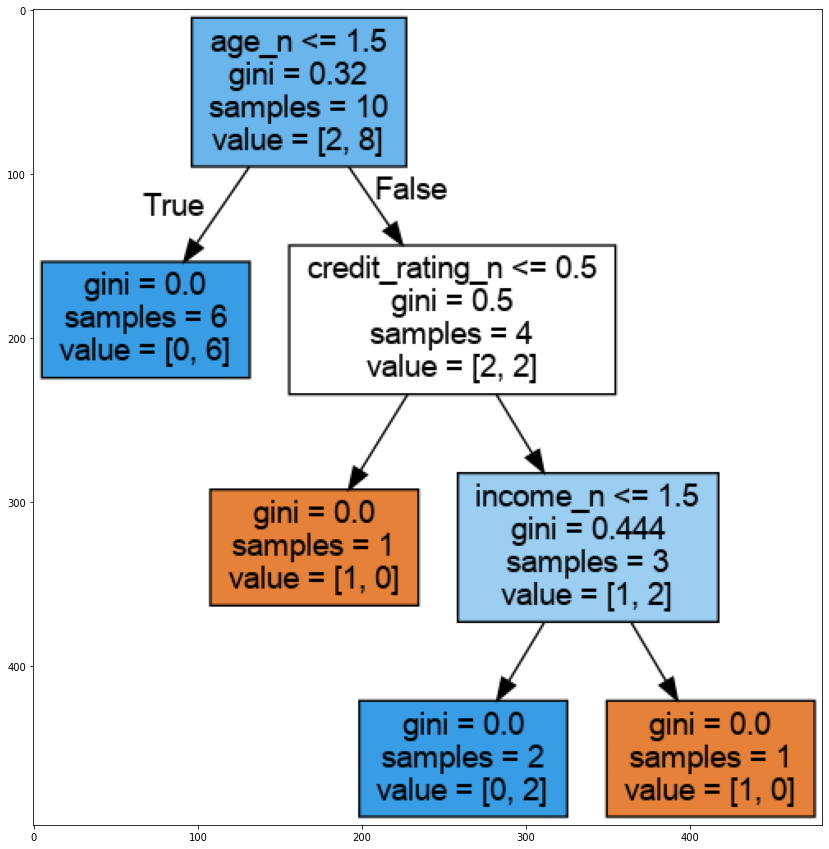

In [126]:
img = plt.imread("buys_computer.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

In [151]:
#Benchmark dataset
from scipy.io import arff
import pandas as pd

data = arff.loadarff('caesarian.arff')
df = pd.DataFrame(data[0])
df_new = df.copy()

print(df.columns)

#Changing the bytes literals
df_new['Age'] = df['Age'].str.decode("utf-8")
df_new['Delivery number'] = df['Delivery number'].str.decode("utf-8")
df_new['Delivery time'] = df['Delivery time'].str.decode("utf-8")
df_new['Blood of Pressure'] = df['Blood of Pressure'].str.decode("utf-8")
df_new['Heart Problem'] = df['Heart Problem'].str.decode("utf-8")
df_new['Caesarian'] = df['Caesarian'].str.decode("utf-8")

Index(['Age', 'Delivery number', 'Delivery time', 'Blood of Pressure',
       'Heart Problem', 'Caesarian'],
      dtype='object')


In [152]:
df_new

,Age,Delivery number,Delivery time,Blood of Pressure,Heart Problem,Caesarian
0,22,1,0,2,0,0
1,26,2,0,1,0,1
2,26,2,1,1,0,0
3,28,1,0,2,0,0
4,22,2,0,1,0,1
...,...,...,...,...,...,...
75,27,2,1,1,0,0
76,33,4,0,1,0,1
77,29,2,1,2,0,1
78,25,1,2,0,0,1


In [153]:
Y = df_new["Caesarian"]
X = df_new.drop(["Caesarian"], axis=1)

In [157]:
model = tree.DecisionTreeClassifier(criterion='entropy')
model.fit(X.values,Y.values)
model.score(X.values,Y.values)

0.95

In [162]:
print(model.predict([[33,4,0,1,0]])[0])
print(model.predict([[28,2,0,1,1]])[0])
print(model.predict([[25,1,0,0,0]])[0])

1
1
0


In [166]:
#Display tree
decision_tree = tree.export_graphviz(model, out_file="caesarian.dot", feature_names=X.columns, max_depth=10, filled=True)

In [167]:
!dot -Tpng caesarian.dot -o caesarian.png

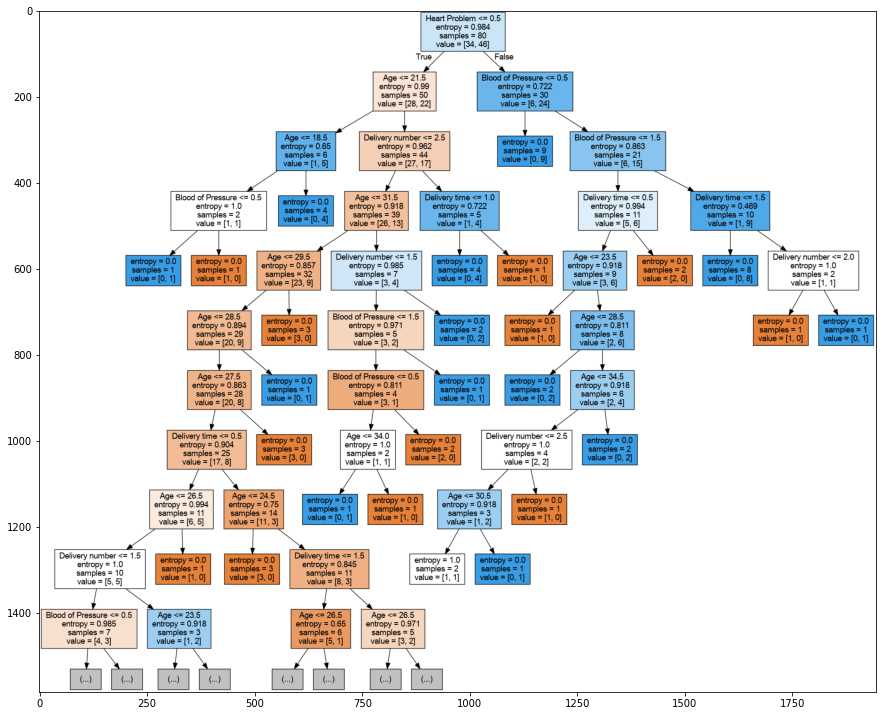

In [168]:
img = plt.imread("caesarian.png")
plt.figure(figsize=(15,15))
plt.imshow(img)